Reddit Depression NLP — Demo Notebook (ipynb Template)

0) Intro & Checklist


环境与依赖安装

读取与清洗数据（UTC 时间标准化）

分词与停用词

词频 / TF‑IDF（unigram）

二元词组（bigram TF‑IDF）

情感与主观性（TextBlob）

月度趋势 + 移动均线

LDA 主题模型（建议用 CountVectorizer）

导出 CSV 与词云

1) Setup

In [3]:
%pip install -q pandas numpy matplotlib plotly textblob wordcloud scikit-learn vaderSentiment


import os, re, sys, warnings
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


pio.templates.default = "plotly_dark"

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Note: you may need to restart the kernel to use updated packages.


2) Load data

In [6]:
# 修改为你的 CSV 路径（建议使用小样本加快演示）
CSV_PATH = "data/depression-sampled.csv" # 例如: /path/to/your.csv


if not os.path.isfile(CSV_PATH):
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}")


df = pd.read_csv(CSV_PATH)


# 保证必要列存在
for col in ["selftext", "title", "author"]:
    if col in df.columns:
        df[col] = df[col].astype(str).fillna("")
    else:
        df[col] = ""


# 过滤无效正文
REMOVED = {"[removed]", "[deleted]", "nan", ""}
mask_valid = ~df["selftext"].str.strip().str.lower().isin(REMOVED)
df = df[mask_valid].copy().reset_index(drop=True)


# 时间列统一为 UTC datetime
if "created_utc" in df.columns:
    df["created_dt"] = pd.to_datetime(df["created_utc"], unit="s", utc=True, errors="coerce")
elif "created" in df.columns:
    df["created_dt"] = pd.to_datetime(df["created"], utc=True, errors="coerce")
else:
    df["created_dt"] = pd.NaT


print(df.shape)
df.head(3)

(26076, 10)


,Unnamed: 0,author,created_utc,full_link,id,num_comments,score,selftext,title,created_dt
0,23864,3dgyT33N666,1602609737,https://www.reddit.com/r/depression/comments/j...,jahyyq,0.0,1.0,Im fucking serious im tired as hell sad as hel...,Dear r/depression,2020-10-13 17:22:17+00:00
1,227300,TallGhostXO,1576632252,https://www.reddit.com/r/depression/comments/e...,ec5gwf,3.0,1.0,I hate myself with a fucking burning passion. ...,I fucking hate myself.,2019-12-18 01:24:12+00:00
2,72985,dojacool,1595740581,https://www.reddit.com/r/depression/comments/h...,hy19hz,4.0,1.0,"This is our conversation last night ,what shou...","We met a year ago, shes from russia and im fro...",2020-07-26 05:16:21+00:00


3) Tokenization

使用正则提取 ≥3 字母的英文 token，保留撇号；

去停用词；

返回干净词序列。

In [7]:
token_re = re.compile(r"[a-z']{3,}", re.IGNORECASE)
stopwords = set("""
a an and are as at be by for from has have i im i'm in is it its it's of on or our so that
the their there they this to was were what when where who why will with you your you're
we we've we'll don't can't won't didn't isn't wasn't shouldnt shouldn't couldnt couldn't
""".replace("’","'").split())


def tokenize(text: str):
    words = token_re.findall(text.lower())
    return [w.strip("'") for w in words if len(w) > 2 and w not in stopwords]


sample = "I'm so, so sad... therapy really helps, but I can't sleep."
print("tokens ->", tokenize(sample))


texts = df["selftext"].tolist()

tokens -> ['sad', 'therapy', 'really', 'helps', 'but', 'sleep']


4) Word frequency & TF‑IDF (unigram)

In [8]:
# 词频
all_tokens = []
for t in texts:
    all_tokens.extend(tokenize(t))
word_counts = Counter(all_tokens)
top20_freq = pd.DataFrame(word_counts.most_common(20), columns=["word","count"])
top20_freq

,word,count
0,but,49274
1,just,43039
2,like,32819
3,feel,28961
4,not,26019
5,all,22658
6,know,20692
7,about,20592
8,want,20251
9,because,19658


In [9]:
# TF‑IDF（unigram）
tfidf_vec = TfidfVectorizer(tokenizer=tokenize, max_features=8000, max_df=0.8, min_df=5)
X = tfidf_vec.fit_transform(texts)
terms = tfidf_vec.get_feature_names_out()


# 汇总各词 TF‑IDF 权重
tfidf_scores = np.asarray(X.sum(axis=0)).ravel()
order = np.argsort(-tfidf_scores)[:20]
top20_tfidf = pd.DataFrame({"word": terms[order], "tfidf_sum": tfidf_scores[order]})
top20_tfidf

,word,tfidf_sum
0,just,1372.838007
1,but,1357.161653
2,like,1100.965823
3,feel,1095.284765
4,not,883.736745
5,want,873.051367
6,all,815.614541
7,know,803.748207
8,can,773.640344
9,life,769.105311


In [10]:
# 可视化（横向条形）
fig = px.bar(top20_tfidf.sort_values("tfidf_sum"), x="tfidf_sum", y="word",
            orientation="h", title="Top 20 Keywords by TF‑IDF")
fig.show()

5) Bigrams (TF‑IDF)

In [11]:
bigram_vec = TfidfVectorizer(
    tokenizer=None, lowercase=True, stop_words="english",
    ngram_range=(2,2), max_df=0.9, min_df=8, max_features=5000,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z']+\b"
)
X2 = bigram_vec.fit_transform(df["selftext"].tolist())
bigrams = bigram_vec.get_feature_names_out()


bigram_scores = np.asarray(X2.sum(axis=0)).ravel()
order2 = np.argsort(-bigram_scores)[:20]
top20_bigrams = pd.DataFrame({"bigram": bigrams[order2], "tfidf_sum": bigram_scores[order2]})
top20_bigrams

,bigram,tfidf_sum
0,feel like,856.459104
1,don't know,457.013233
2,don know,421.131569
3,just want,405.745875
4,don't want,307.420589
5,don want,286.692750
6,feels like,266.051566
7,just feel,263.123266
8,i'm just,236.025112
9,like i'm,204.457786


6) Sentiment & Subjectivity (TextBlob)

In [12]:
df["polarity"] = df["selftext"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["subjectivity"] = df["selftext"].apply(lambda x: TextBlob(x).sentiment.subjectivity)


df[["selftext","polarity","subjectivity"]].head(3)

,selftext,polarity,subjectivity
0,Im fucking serious im tired as hell sad as hel...,-0.144898,0.606463
1,I hate myself with a fucking burning passion. ...,-0.266667,0.610417
2,"This is our conversation last night ,what shou...",0.171566,0.477656


In [13]:
fig1 = px.violin(df.sample(min(4000, len(df)), random_state=42),
                y="polarity", box=True, points="suspectedoutliers",
                title="Sentiment Polarity Distribution")
fig1.add_hline(y=0, line_dash="dash", line_color="gray")
fig1.show()


fig2 = px.histogram(df, x="subjectivity", nbins=40, title="Subjectivity Histogram")
fig2.update_layout(bargap=0.05)
fig2.show()

7) Monthly trend + Moving Averages

In [14]:
time_df = df[["created_dt"]].dropna().copy()
if not time_df.empty:
    monthly = (
        time_df.set_index("created_dt").resample("MS").size().reset_index(name="post_count")
)
    monthly["month"] = monthly["created_dt"].dt.strftime("%Y-%m")
    monthly["ma3"] = monthly["post_count"].rolling(3, min_periods=1).mean()
    monthly["ma6"] = monthly["post_count"].rolling(6, min_periods=1).mean()


    fig = go.Figure()
    fig.add_trace(go.Scatter(x=monthly["created_dt"], y=monthly["post_count"],
                            mode="lines+markers", name="Monthly Posts"))
    fig.add_trace(go.Scatter(x=monthly["created_dt"], y=monthly["ma3"],
                            mode="lines", name="MA(3)", line=dict(width=3)))
    fig.add_trace(go.Scatter(x=monthly["created_dt"], y=monthly["ma6"],
                            mode="lines", name="MA(6)", line=dict(width=3, dash="dash")))
    fig.update_layout(title="Monthly Post Count (with Moving Averages)",
                    xaxis_title="Month", yaxis_title="Post Count", height=480)
    fig.show()
else:
    monthly = pd.DataFrame(columns=["created_dt","post_count","month","ma3","ma6"])
    print("No datetime available.")

8) LDA Topic Modeling

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

N_TOPICS = 6  # 可调
count_vec = CountVectorizer(tokenizer=tokenize, max_features=8000, max_df=0.8, min_df=5)
Xc = count_vec.fit_transform(texts)
terms_c = count_vec.get_feature_names_out()

lda = LatentDirichletAllocation(n_components=N_TOPICS, random_state=42, learning_method="batch")

if Xc.shape[0] > 0 and Xc.shape[1] > 0:
    lda.fit(Xc)

    # 1) 展示每个主题的 Top-12 词（表格）
    topic_terms = []
    for k in range(N_TOPICS):
        comp = lda.components_[k]
        top_ids = np.argsort(comp)[-12:][::-1]
        topic_terms.append([terms_c[i] for i in top_ids])

    topic_df = pd.DataFrame(
        topic_terms,
        index=[f"Topic {i+1}" for i in range(N_TOPICS)],
        columns=[f"t{j+1}" for j in range(12)]
    )
    display(topic_df)

    # 2) 热力图（按每个主题的 Top-20 词显示权重）
    topic_term_matrix = []
    term_labels = []
    for k in range(N_TOPICS):
        comp = lda.components_[k]
        top_ids = np.argsort(comp)[-20:][::-1]
        topic_term_matrix.append(comp[top_ids])
        term_labels.append([terms_c[i] for i in top_ids])

    tm = np.vstack(topic_term_matrix)  # (K, 20)
    term_axis = term_labels[0] if len(term_labels) > 0 else [f"term{i+1}" for i in range(tm.shape[1])]

    fig_lda = go.Figure(data=go.Heatmap(
        z=tm,
        x=term_axis,
        y=[f"Topic {i+1}" for i in range(tm.shape[0])],
        colorscale="Viridis",
        colorbar=dict(title="Weight")
    ))
    fig_lda.update_layout(
        title=f"LDA Topics × Top Terms Heatmap (K={N_TOPICS})",
        xaxis_title="Top Terms", yaxis_title="Topics", height=500
    )
    fig_lda.show()
else:
    print("Empty matrix for LDA.")


,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12
Topic 1,but,been,get,just,job,now,out,had,work,because,all,not
Topic 2,but,not,can,just,all,people,life,depression,help,some,feel,more
Topic 3,just,but,like,get,not,dont,all,want,even,her,feel,know
Topic 4,she,her,but,had,him,about,because,out,just,would,told,not
Topic 5,feel,just,but,like,don,know,want,about,not,people,can,really
Topic 6,life,just,want,all,but,fucking,myself,not,like,die,hate,never


9) Exports (CSV)

In [20]:
from IPython.display import display, HTML

print("Top 20 Most Frequent Words")
display(top20_freq)

print("\nTop 20 Keywords by TF-IDF")
display(top20_tfidf)

print("\nTop 20 Bigrams by TF-IDF")
display(top20_bigrams)

# 如果你还想给月度趋势一个快速预览，这里展示头几行
if 'monthly' in globals() and not monthly.empty:
    print("\nMonthly Trend (head)")
    display(monthly.head(12))
else:
    print("\nMonthly Trend: <no data>")


Top 20 Most Frequent Words


,word,count
0,but,49274
1,just,43039
2,like,32819
3,feel,28961
4,not,26019
5,all,22658
6,know,20692
7,about,20592
8,want,20251
9,because,19658



Top 20 Keywords by TF-IDF


,word,tfidf_sum
0,just,1372.838007
1,but,1357.161653
2,like,1100.965823
3,feel,1095.284765
4,not,883.736745
5,want,873.051367
6,all,815.614541
7,know,803.748207
8,can,773.640344
9,life,769.105311



Top 20 Bigrams by TF-IDF


,bigram,tfidf_sum
0,feel like,856.459104
1,don't know,457.013233
2,don know,421.131569
3,just want,405.745875
4,don't want,307.420589
5,don want,286.692750
6,feels like,266.051566
7,just feel,263.123266
8,i'm just,236.025112
9,like i'm,204.457786



Monthly Trend (head)


,created_dt,post_count,month,ma3,ma6
0,2019-07-01 00:00:00+00:00,239,2019-07,239.000000,239.000000
1,2019-08-01 00:00:00+00:00,1695,2019-08,967.000000,967.000000
2,2019-09-01 00:00:00+00:00,1708,2019-09,1214.000000,1214.000000
3,2019-10-01 00:00:00+00:00,1893,2019-10,1765.333333,1383.750000
4,2019-11-01 00:00:00+00:00,1898,2019-11,1833.000000,1486.600000
5,2019-12-01 00:00:00+00:00,1952,2019-12,1914.333333,1564.166667
6,2020-01-01 00:00:00+00:00,1930,2020-01,1926.666667,1846.000000
7,2020-02-01 00:00:00+00:00,1775,2020-02,1885.666667,1859.333333
8,2020-03-01 00:00:00+00:00,1612,2020-03,1772.333333,1843.333333
9,2020-04-01 00:00:00+00:00,1484,2020-04,1623.666667,1775.166667


10) Wordcloud

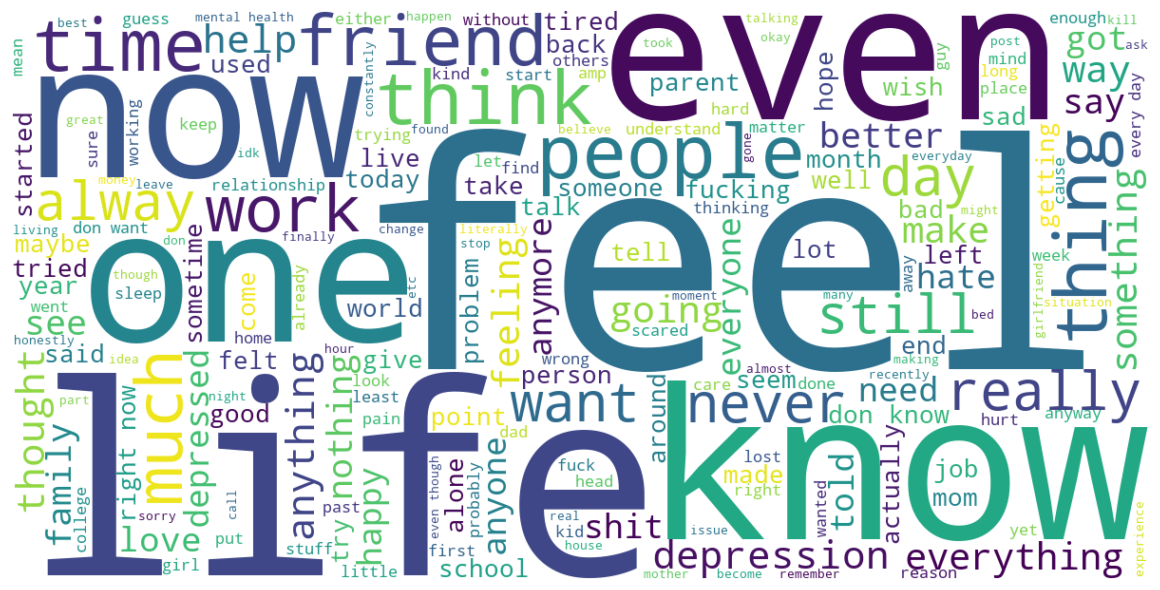

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

if len(all_tokens) > 0:
    wc = WordCloud(width=1200, height=600, background_color="white").generate(" ".join(all_tokens))
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No tokens for wordcloud.")


11) Dataset Summary

In [18]:
n_posts = len(df)
n_authors = df["author"].nunique()
avg_words = float(np.mean([len(tokenize(t)) for t in df["selftext"]])) if n_posts > 0 else 0.0


if df["created_dt"].notna().any():
    date_min = pd.to_datetime(df["created_dt"].min()).strftime("%Y-%m-%d")
    date_max = pd.to_datetime(df["created_dt"].max()).strftime("%Y-%m-%d")
else:
    date_min = date_max = "N/A"


print("\n===== Dataset Summary =====")
print(f"Posts: {n_posts}")
print(f"Unique authors: {n_authors}")
print(f"Avg words per post (selftext): {avg_words:.2f}")
print(f"Date range (UTC): {date_min} → {date_max}\n")


===== Dataset Summary =====
Posts: 26076
Unique authors: 22235
Avg words per post (selftext): 99.78
Date range (UTC): 2019-07-28 → 2020-11-24

